## Librerías

In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lightgbm as lgb




from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from time import time
import duckdb
# %load_ext sql
# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False
# %sql duckdb:///:memory:
import time
import optuna
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState

from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history
import plotly.express as px
import shap
import os

import kaggle 
import glob



In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [4]:
semillas =[ 400009,  500009,  600011,  700021,  800021]

In [5]:

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104
mes_test = 202106


In [7]:
# sacadas por data drifting

df_train = df_train.drop(columns=['cprestamos_personales','mprestamos_personales','Master_fultimo_cierre','Visa_fultimo_cierre'])

NameError: name 'df_train' is not defined

In [15]:
df_gbm = df_train.copy() 

In [16]:
df_gbm['clase_binaria1'] = 0
df_gbm['clase_binaria2'] = 0
df_gbm['clase_binaria1'] = np.where(df_gbm['clase_ternaria'] == 'BAJA+2', 1, 0)
df_gbm['clase_binaria2'] = np.where(df_gbm['clase_ternaria'] == 'CONTINUA', 0, 1)

In [17]:
df_gbm['clase_peso'] = 1.0

df_gbm.loc[df_gbm['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_gbm.loc[df_gbm['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [18]:
train_data = df_gbm[df_gbm['foto_mes'] == mes_train]
test_data = df_gbm[df_gbm['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

In [19]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

In [20]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train )
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train )

In [21]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

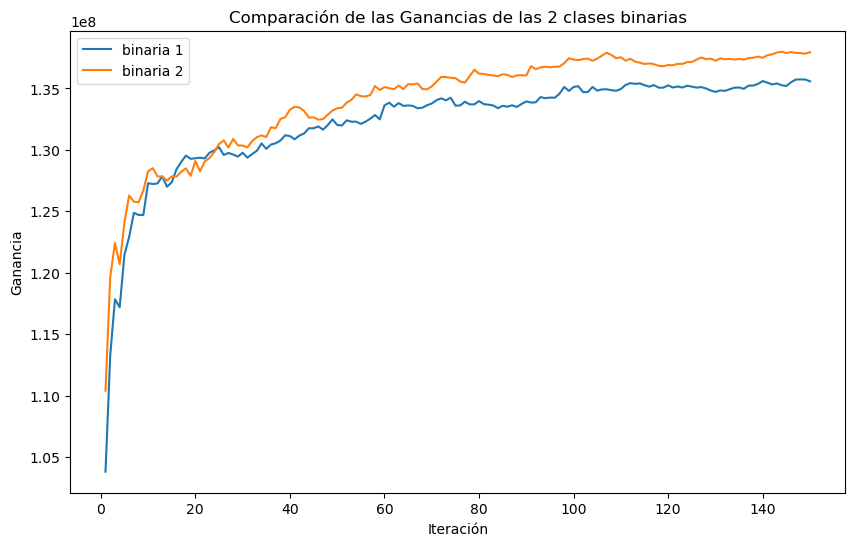

In [577]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

# Experimento

In [8]:
df_train = pd.read_csv(r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\Git\dmeyf2024\datasets\competencia_01.csv")

In [9]:
df_train['clase_peso'] = 1.0
df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [10]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [12]:
df_train['clase_ternaria'].value_counts()

clase_ternaria
CONTINUA    645039
BAJA+1      169504
BAJA+2      167403
Name: count, dtype: int64

In [18]:
df_train['clase_binaria'] = np.where(df_train['clase_ternaria']=='CONTINUA', 0, 1)

In [19]:
f_test = df_train.query('foto_mes == 202106')
df_test = df_train.loc[f_test.index, : ]


In [20]:
clase_peso = df_train['clase_peso']
X_train = df_train.drop(['clase_ternaria', 'clase_binaria', 'clase_peso'], axis=1)
Y_train =df_train['clase_binaria']
X_test = df_test.drop(['clase_ternaria', 'clase_binaria', 'clase_peso'], axis=1)
Y_test =df_test['clase_binaria']

In [21]:
def objective(trial):
    num_leaves = trial.suggest_int('num_leaves', 8, 100)
    learning_rate = trial.suggest_float('learning_rate', 0.00005, 0.3)  # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 2000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0)

    params = {
        'objective': 'binary',
        'metric': 'custom', 
        'boosting_type': 'gbdt',
        'device': 'gpu',  # Usar la GPU
        'gpu_platform_id': 0,  # (opcional) ID de la plataforma GPU
        'gpu_device_id': 0,     # (opcional) ID del dispositivo GPU
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'device': 'gpu',
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }

    train_data = lgb.Dataset(X_train,
                             label=Y_train,  # elegir la clase
                             weight=clase_peso)
                             
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=300,  # modificar, subir y subir... y descomentar la línea inferior
        
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )

    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = r"sqlite:///C:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\Optuna\rf_segmentacion1\optimization_tree.db"
study_name = "experimento_trazas_data"



study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

import optuna

class EarlyStoppingByImprovement:
    def __init__(self, patience: int):
        """
        Args:
            patience (int): Número de pruebas consecutivas sin mejora antes de detener la optimización.
        """
        self.patience = patience
        self.best_value = None
        self.no_improvement_trials = 0

    def __call__(self, study, trial):
        current_best_value = study.best_trial.value

        # Si la métrica mejora, reseteamos el contador
        if self.best_value is None or current_best_value > self.best_value:
            self.best_value = current_best_value
            self.no_improvement_trials = 0
        else:
            # Si no hay mejora, incrementamos el contador
            self.no_improvement_trials += 1

        # Detener si no ha habido mejora en 'self.patience' pruebas consecutivas
        if self.no_improvement_trials >= self.patience:
            print(f"Early stopping: No hay mejora en {self.patience} pruebas consecutivas.")
            study.stop()

# Crear el callback con 100 pruebas consecutivas sin mejora
early_stopping_callback = EarlyStoppingByImprovement(patience=300)

# Crear el estudio
study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

# Optimizar el estudio con el callback personalizado
study.optimize(objective, n_trials=30000)


[I 2024-11-01 21:28:48,620] Using an existing study with name 'experimento_trazas_data' instead of creating a new one.
[I 2024-11-01 21:28:48,656] Using an existing study with name 'experimento_trazas_data' instead of creating a new one.
[I 2024-11-01 21:30:08,362] Trial 5 finished with value: 10737355816.0 and parameters: {'num_leaves': 38, 'learning_rate': 0.13480169325383795, 'min_data_in_leaf': 367, 'feature_fraction': 0.7406579782085484, 'bagging_fraction': 0.1415544063764994}. Best is trial 5 with value: 10737355816.0.
[I 2024-11-01 21:31:43,541] Trial 6 finished with value: 10737334816.0 and parameters: {'num_leaves': 52, 'learning_rate': 0.2986074479471136, 'min_data_in_leaf': 516, 'feature_fraction': 0.5825533658887233, 'bagging_fraction': 0.2721351382597599}. Best is trial 5 with value: 10737355816.0.
[I 2024-11-01 21:33:34,686] Trial 7 finished with value: 10737313816.0 and parameters: {'num_leaves': 97, 'learning_rate': 0.04707759144417927, 'min_data_in_leaf': 159, 'feature

KeyboardInterrupt: 

In [22]:
study.best_params

{'num_leaves': 51,
 'learning_rate': 0.13870336045994874,
 'min_data_in_leaf': 776,
 'feature_fraction': 0.7119923826207131,
 'bagging_fraction': 0.627883478400356}

In [579]:
best_params = {'num_leaves': 76, 'learning_rate': 0.04264413547569725, 'min_data_in_leaf': 766, 'feature_fraction': 0.8987812271100075, 'bagging_fraction': 0.6737761560342819}


In [580]:
# optuna.visualization.plot_optimization_history(study)

In [581]:
# plot_param_importances(study)

In [582]:
# plot_slice(study)

In [23]:
w_train = df_train.loc[X_train.index, 'clase_peso']

best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_params['num_leaves'],
    'learning_rate': study.best_params['learning_rate'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'feature_fraction': study.best_params['feature_fraction'],
    'bagging_fraction': study.best_params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label= Y_train,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 283


In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [25]:
shap_df = pd.DataFrame(shap_values, columns = X_train.columns)
shap_df

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,0.010037,-6.160762,-0.002981,0.000422,-0.002635,-0.053066,-0.049811,0.056300,-0.004194,-0.009676,...,0.0,-0.521222,-0.005699,-0.168166,0.009052,-0.139515,0.069256,0.054289,0.0,-0.400873
1,0.222062,-5.793181,-0.002245,0.000183,0.002829,-0.120017,0.170101,-0.021941,-0.116167,-0.002599,...,0.0,-0.461153,-0.009286,0.121774,-0.000314,0.153909,0.016472,0.038007,0.0,-0.049618
2,0.072694,-5.981195,-0.002380,0.000398,0.002209,-0.116045,-0.112142,0.027015,-0.065158,0.006063,...,0.0,-0.366360,-0.006168,-0.087495,0.006140,-0.133304,-0.007267,-0.082207,0.0,-0.283839
3,0.049202,-5.444368,-0.007144,-0.000086,0.005852,0.153562,0.018665,-0.188983,0.182499,-0.017563,...,0.0,-0.379034,-0.034454,-0.056010,0.016932,-0.117705,-0.002682,-0.035950,0.0,0.077824
4,0.092263,-5.749915,-0.003900,-0.000083,-0.001129,0.278451,0.060917,-0.063967,-0.263292,-0.095945,...,0.0,-0.536280,-0.014928,-0.004730,0.012467,0.073242,-0.000468,-0.020002,0.0,0.035582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981941,0.010454,11.043201,0.121904,-0.000085,0.009081,0.097263,-0.039242,-0.057279,0.089843,-0.004348,...,0.0,0.086753,-0.013013,0.024025,0.010640,0.036792,0.002499,-0.039967,0.0,0.097580
981942,0.051735,11.144780,-0.001460,0.000394,0.009292,0.044418,-0.061971,-0.022084,0.121041,-0.006667,...,0.0,0.091636,-0.012478,0.015110,0.007882,-0.183246,0.006679,-0.039975,0.0,0.061727
981943,0.039082,11.105130,0.147785,0.000394,0.009670,0.055700,-0.069155,-0.018137,0.116875,-0.003371,...,0.0,0.095263,-0.012312,0.016562,0.007346,-0.251888,0.006737,-0.040349,0.0,0.065176
981944,0.037426,10.917088,0.113750,0.000395,0.008529,0.098973,0.007877,-0.043610,0.112312,-0.002327,...,0.0,0.672840,-0.008911,0.027065,0.008807,-0.033974,0.003825,-0.047031,0.0,0.075757


In [ ]:
# best_iter = study.best_trial.user_attrs["best_iter"]
# print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
# params = {
#     'objective': 'binary',
#     'boosting_type': 'gbdt',
#     'first_metric_only': True,
#     'boost_from_average': True,
#     'feature_pre_filter': False,
#     'max_bin': 31,
#     'num_leaves': study.best_params['num_leaves'],
#     'learning_rate': study.best_params['learning_rate'],
#     'min_data_in_leaf': study.best_params['min_data_in_leaf'],
#     'feature_fraction': study.best_params['feature_fraction'],
#     'bagging_fraction': study.best_params['bagging_fraction'],
#     'seed': semillas[0],
#     'verbose': 0
# }

# train_data = lgb.Dataset(X_train,
#                           label=y_train_binaria2,
#                           weight=w_train)

# model = lgb.train(params,
#                   train_data,
#                   num_boost_round=best_iter)

Mejor cantidad de árboles para el mejor model 141


In [585]:
# mes_test = 202106
# test_data = df_gbm[df_gbm['foto_mes'] == mes_test]


# X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
# y_test_binaria1 = test_data['clase_binaria1']
# y_test_class = test_data['clase_ternaria']
# w_test = test_data['clase_peso']

In [586]:
X_test.shape

(164876, 150)

In [587]:
y_pred_lgm = model.predict(X_test)

In [588]:
y_pred_labels = (y_pred_lgm > 0.025).astype(int)


In [589]:
#dataframe con las variables más importantes
importancias = model.feature_importance()
nombres = model.feature_name()
df_variables_importantes = pd.DataFrame({'importancia': importancias, 'variable': nombres})
df_variables_importantes = df_variables_importantes.sort_values(by='importancia', ascending=False)
lista_variables_importantes =  df_variables_importantes['variable'].head(10).to_list()

In [590]:
df_resultado = pd.DataFrame({
    'numero_de_cliente': X_test['numero_de_cliente'],
    'Predicted': y_pred_labels
})

In [591]:

# numero = '006'
# entrega = f'entrega_{numero}.csv'
# path = r"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\Entregas"
# archivos = glob.glob(os.path.join(path, '*'))
# archivos.sort(key=os.path.getmtime, reverse=True)
# ultimo_archivo = archivos[0] if archivos else None
# if ultimo_archivo:
#     nombre_archivo = os.path.basename(ultimo_archivo)
#     numero = ''.join(filter(str.isdigit, nombre_archivo))
#     print(f"El último archivo entregado es: {nombre_archivo}")
#     print(f"El número extraído es: {numero}")
# else:
#     print("No se encontraron archivos en la carpeta.")


 

In [592]:
#Ingresar el path sobre el cual se quiere ingresar el archivo a entregar

entrega = df_resultado.to_csv(r"C:\Users\Admin\Desktop\replicabilidad_competencia_01\competencia_01_replicabilidad.csv", index=False)

In [593]:

# numero = '073'
# entrega = f'entrega_{numero}.csv'

In [594]:


# if os.path.exists(path + entrega):
#     print("El archivo ya existe")
# else:
#     entrega_final = os.path.join(path, entrega)
#     df_resultado.to_csv(entrega_final, index=False)
    


In [595]:
# entrega_final

In [596]:
# cantidad_columnas = df_gbm.shape[1]
# message = f"{entrega}, cantidad de columnas en el train: {cantidad_columnas}, modelo: LGBM, mejores parametros: {best_params}, mejor iteracion: {best_iter}, archivo: {entrega_final}"

<!-- ### Kaggle -->

In [597]:

# entrega_final = os.path.join(path, entrega)
# entrega_final
# competition= 'dm-ey-f-2024-primera'

In [598]:
# kaggle.api.competition_submit(competition=competition, file_name= entrega_final, message=message, quiet=False)

## Consejo de especialistas

In [599]:
# df_abril = df_train[df_train['foto_mes'] == 202104]
# df_abril.shape
# df_abril['clase_ternaria'] = df_abril['clase_ternaria'].map(lambda x: 0 if x == 'CONTINUA' else 1)

In [600]:
# df_junio = df_train[df_train['foto_mes'] == 202106]
# clientes_unicos = df_junio['numero_de_cliente'].unique()

In [601]:
# junio_en_abril = df_abril.loc[df_abril['numero_de_cliente'].isin(clientes_unicos), 'clase_ternaria']

In [602]:
# Xtrain_rf = df_abril
# ytrain_rf = Xtrain_rf["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
# Xtrain_rf = Xtrain_rf.drop("clase_ternaria", axis=1)

In [603]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)


In [604]:
# Xtrain_rf_imp.shape

In [605]:
# embedding_rf = UMAP(
#   n_components=4,
#   n_neighbors=50,
#   metric="minkowski",
#   random_state=17,
# ).fit_transform(Xtrain_rf_imp)

# plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

In [606]:
# hdb = DBSCAN(eps=0.3)
# y = hdb.fit(embedding_rf)

# plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
# plt.tight_layout()
# plt.show()

In [607]:
# df_abril['clase_ternaria'].value_counts()

In [608]:


# embedding_df = pd.DataFrame(embedding_rf, columns=['UMAP_1', 'UMAP_2'])

# df_abril = df_abril.reset_index(drop=True)
# df_abril = pd.concat([df_abril, embedding_df], axis=1)

# df_abril['cluster'] = y.labels_



In [609]:
# # Crear un mapa de colores para las clases
# class_colors = {0: 'blue', 1: 'red'}  # Colores para las dos clases
# class_names = {0: 'CONTINUA', 1: 'BAJA'}  # Etiquetas para las clases

# plt.figure(figsize=(10, 7))

# # Obtener etiquetas de clúster únicas
# clusters_unique = df_abril['cluster'].unique()

# # Graficar cada clúster y clase
# for cluster in clusters_unique:
#     # Indices de los puntos en este clúster
#     idx = df_abril['cluster'] == cluster
#     # Obtener las etiquetas de clase de estos puntos
#     classes_in_cluster = df_abril.loc[idx, 'clase_ternaria']
#     # Colorear puntos según su clase
#     for class_value in [0, 1]:  # Asumiendo dos valores de clase (0, 1)
#         idx_class = idx & (df_abril['clase_ternaria'] == class_value)
#         if np.any(idx_class):
#             plt.scatter(
#                 df_abril.loc[idx_class, 'UMAP_1'],
#                 df_abril.loc[idx_class, 'UMAP_2'],
#                 color=class_colors[class_value],
#                 label=f'Clúster {cluster}, {class_names[class_value]}',
#                 edgecolor='k',
#                 s=50,
#                 alpha=0.5
#             )



# # Configuración de la gráfica
# plt.xlabel('Componente UMAP 1')
# plt.ylabel('Componente UMAP 2')
# plt.title('Distribución de Clases en los Clústeres')
# plt.tight_layout()
# plt.show()



In [610]:
# df_abril.groupby('cluster')['clase_ternaria'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['blue', 'red'])


### Puntos de corte

In [611]:

# predicciones = y_pred_lgm

# X_test['Probabilidad'] = predicciones

# tb_entrega = X_test.sort_values(by='Probabilidad', ascending=False)

# cortes = range(9000,14000,100)

# num_subida_kaggle = 65
# for envios in cortes:
    
#     tb_entrega['Predicted'] = 0
#     tb_entrega.iloc[:envios, tb_entrega.columns.get_loc('Predicted')] = 1
#     resultados = tb_entrega[["numero_de_cliente", 'Predicted']].reset_index(drop=True)
    
#     print("Cantidad de clientes {}".format(envios))
    
#     nombre_archivo = 'entrega_0{}.csv'.format(num_subida_kaggle)
#     entrega_final = os.path.join(path, nombre_archivo)
#     resultados.to_csv(entrega_final, index=False)
    
    
#     cantidad_columnas = df_train.shape[1]
#     message = f"{entrega}, cantidad de columnas en el train: {cantidad_columnas}, modelo: LGBM, mejores parametros: {best_params}, mejor iteracion: {best_iter}, archivo: {entrega_final}, punto de corte: {envios}, optimizado con optuna: {study_name}"
    
#     num_subida_kaggle += 1
    
    
    
#     entrega_final = os.path.join(path, nombre_archivo)   
#     competencia = 'dm-ey-f-2024-primera'
#     try:
#         api.competition_submit(file_name=entrega_final,message=message,competition=competencia)
#     except:
#         print(f"Numero máximo de envios, último envio ={num_subida_kaggle}")

In [612]:
# df_train.shape

In [613]:
# nombre_modelo = 'lgbm_e_en_abril_p_en_junio_451_features.txt'
# model.save_model(rf"C:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\modelos_lgbm\{nombre_modelo}")